In [ ]:
import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import numpy as np
import seaborn as sns
import itertools
import os


def windowed_average(arr, window_size):
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")

    if window_size > len(arr):
        raise ValueError("Window size must not be larger than the array size.")

    kernel = np.full(window_size, 1 / window_size)
    padded_arr = np.pad(arr, (window_size // 2, window_size // 2), mode='edge')
    return np.convolve(padded_arr, kernel, mode='valid')


In [177]:
# RESULT_DIR = "./curated_experiments/energy_entropy_trend_in_n/1htanh_h4_20230401/"
# RESULT_DIR = "./curated_experiments/energy_entropy_trend_in_n/1htanh_h4_narrowband_20230402/"
# RESULT_DIR = "./curated_experiments/energy_entropy_trend_in_n/1htanh_h3_in2_20230402/"
# RESULT_DIR = "./curated_experiments/energy_entropy_trend_in_n/1htanh_h10_20230404/"
RESULT_DIR = "./curated_experiments/energy_entropy_trend_in_n/1htanh_h8_unreal/"

with open(f"{RESULT_DIR}/all_result.json") as infile:
    all_result = json.load(infile)
print(f"Num experiments: {len(all_result)}")

rec = []
for x in all_result:
#     enll = x["output"]["enll"]
    enll = np.median(x["output"]["chain_enlls"])
    rec.append([
        x["rng_seed"], 
        x["itemp"], 
        x["num_training_data"], 
        enll, 
        x["output"]["chain_enlls_std"],
        x["output"]["wall_time_taken"], 
    ])
df_result = pd.DataFrame(
    rec, 
    columns=["rng_seed", "itemp", "num_training_data", "enll", "chain_enlls_std", "time_taken"]
)

df_result

Num experiments: 660


,rng_seed,itemp,num_training_data,enll,chain_enlls_std,time_taken
0,48,0.138605,7500,15879.552734,127.392235,766.929766
1,48,0.132896,5500,9280.410645,69.666824,560.403153
2,42,0.115720,8500,12480.040527,48.495090,851.899568
3,41,0.132896,5500,8982.380859,117.338058,574.381123
4,47,0.104683,9000,20049.501953,21.672459,900.651623
...,...,...,...,...,...,...
655,48,0.115720,8500,11764.108398,132.471405,864.395186
656,42,0.105327,8500,12592.542969,153.787140,865.068302
657,41,0.114284,9500,16594.500977,911.069214,940.831777
658,44,0.107579,7000,26015.459961,1629.208984,854.931179


Max time taken. 24.30 minutes


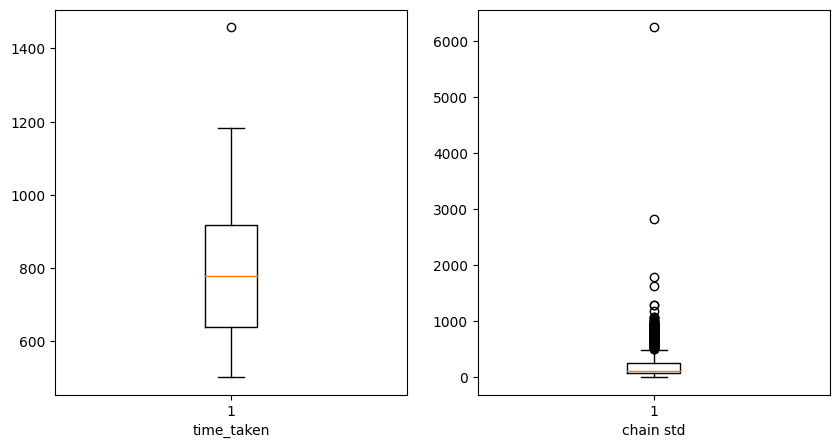

In [191]:

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.boxplot(df_result["time_taken"])
ax.set_xlabel("time_taken")

ax = axes[1]
ax.boxplot(df_result["chain_enlls_std"])
ax.set_xlabel("chain std")
# ax.set_yscale('log')
print(f"Max time taken. {df_result['time_taken'].max() / 60:.2f} minutes")

In [171]:
g = df_result.groupby(["rng_seed", "num_training_data"])
rec = []
for (seed, n), df in g:
    itemps = df["itemp"]
    enlls = df["enll"]
    slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps, enlls)
    rec.append([seed, n, slope, intercept / n, r_val**2])
    
ESTLAMBDA_KEY = "$\hat{\lambda}$"
ESTENERGY_KEY = "$\hat{L_n}(w_0)$"
RSQUARED_KEY = "$R^2$"
df_estimates = pd.DataFrame(rec, columns=["rng_seed", "num_training_data", ESTLAMBDA_KEY, ESTENERGY_KEY, RSQUARED_KEY])

min_rsquared = df_estimates["$R^2$"].min()
print(f"Min $R^2$: {min_rsquared:.4f}")
df_estimates

Min $R^2$: 0.0000


,rng_seed,num_training_data,$\hat{\lambda}$,$\hat{L_n}(w_0)$,$R^2$
0,40,5000,15.372160,1.373231,0.991849
1,40,5500,15.738494,0.214981,0.977868
2,40,6000,15.929980,1.106505,0.971469
3,40,6500,15.357262,1.520986,0.964526
4,40,7000,18.929570,1.121425,0.991059
...,...,...,...,...,...
105,49,8000,4.147246,1.144510,0.045301
106,49,8500,71.420474,0.812172,0.370402
107,49,9000,7.791633,2.666733,0.076271
108,49,9500,-15.184376,2.432830,0.038174


,num_training_data,$\hat{\lambda}$,$\hat{L_n}(w_0)$,$R^2$
0,5000,13.597095,1.717395,0.669882
1,5500,9.815285,1.656052,0.696678
2,6000,21.473477,1.394523,0.815551
3,6500,15.631111,1.990300,0.642298
4,7000,17.989132,2.036556,0.706975
5,7500,1.403179,1.699316,0.640633
6,8000,12.531904,2.091443,0.567348
7,8500,12.569160,1.648725,0.496014
8,9000,14.517645,1.662970,0.572038
9,9500,16.088367,2.179601,0.563048


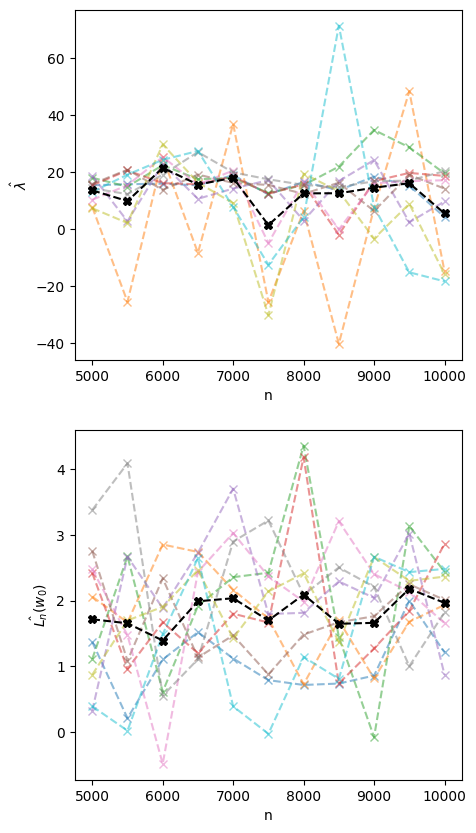

In [172]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10))

for seed, df in df_estimates.groupby("rng_seed"):
    nums = df["num_training_data"]
    lmbdas = df[ESTLAMBDA_KEY]
    energies = df[ESTENERGY_KEY]
    ax = axes[0]
    ax.plot(nums, lmbdas, "x--", alpha=0.5)
    ax.set_xlabel("n")
    ax.set_ylabel(ESTLAMBDA_KEY)
#     ax.set_xscale("log")

    ax = axes[1]
    ax.plot(nums, energies, "x--", alpha=0.5)
    ax.set_xlabel("n")
    ax.set_ylabel(ESTENERGY_KEY);

    
df = df_estimates.groupby("num_training_data").agg("mean")
nums = df.index
lmbdas = df[ESTLAMBDA_KEY]
energies = df[ESTENERGY_KEY]
ax = axes[0]
ax.plot(nums, lmbdas, "kX--")
ax.set_xlabel("n")
ax.set_ylabel(ESTLAMBDA_KEY)
#     ax.set_xscale("log")

ax = axes[1]
ax.plot(nums, energies, "kX--")
ax.set_xlabel("n")
ax.set_ylabel("$\hat{L_n}(w_0)$");


df.drop("rng_seed", axis=1).reset_index()

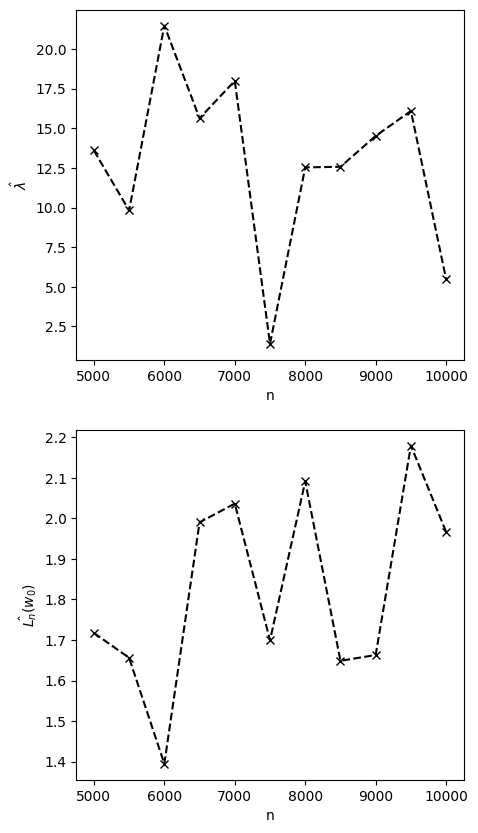

In [173]:
df = df_estimates.groupby("num_training_data").agg("mean")
fig, axes = plt.subplots(2, 1, figsize=(5, 10))

nums = df.index
lmbdas = df[ESTLAMBDA_KEY]
energies = df[ESTENERGY_KEY]
ax = axes[0]
ax.plot(nums, lmbdas, "kx--")
ax.set_xlabel("n")
ax.set_ylabel("$\hat{\lambda}$")
#     ax.set_xscale("log")

ax = axes[1]
ax.plot(nums, energies, "kx--")
ax.set_xlabel("n")
ax.set_ylabel("$\hat{L_n}(w_0)$");


# Generalisation experiment

In [298]:
RESULT_DIR = "./genexpt/20230414_relu_trained//"

with open(f"{RESULT_DIR}/all_result.json") as infile:
    all_result = json.load(infile)
print(f"Num experiments: {len(all_result)}")

rec = []
for x in all_result:
    rec.append([
        x["n"], 
        x["BL"], 
        x["Bg"]
    ])
df_result = pd.DataFrame(
    rec, 
    columns=["n", "BL", "Bg"]
).sort_values("n")

df_result

Num experiments: 591


,n,BL,Bg
30,50,1.766394,0.375991
78,55,1.670829,0.306887
325,60,1.797817,0.395126
148,65,1.675979,0.273214
502,70,1.683831,0.283291
...,...,...,...
319,2980,1.428803,0.026165
343,2985,1.420768,0.024032
70,2990,1.410442,0.026581
169,2995,1.459240,0.023847


591


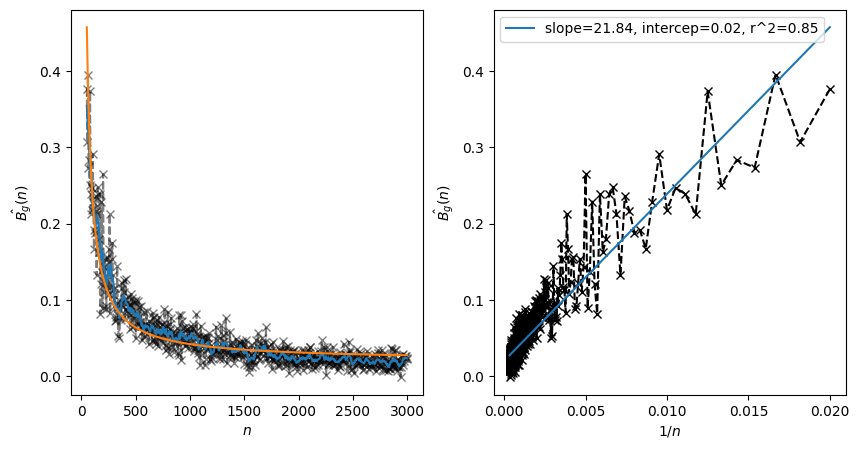

In [299]:
df = df_result
print(df.shape[0])
slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / df["n"], df["Bg"])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.plot(df["n"], df["Bg"], "kx--", alpha=0.5)
ax.set_xlabel("$n$")
ax.set_ylabel("$\hat{B_g}(n)$")
ax.plot(df["n"], windowed_average(df["Bg"], window_size=7))

xs = df['n']
xrange = np.linspace(xs.min(), xs.max(), num=100)
ax.plot(xs, slope / xs + intercept)
# ax.set_xscale("log");


ax = axes[1]
ax.plot(1 / df["n"], df["Bg"], "kx--")
ax.set_xlabel("$1/n$")
ax.set_ylabel("$\hat{B_g}(n)$")

xs = 1.0 / df['n']
xrange = np.linspace(xs.min(), xs.max(), num=100)
ax.plot(xrange, slope * xrange + intercept, label=f"slope={slope:.2f}, intercep={intercept:.2f}, r^2={r_val**2:.2f}")
ax.legend();



## With multiple rng seed

Num experiments: 338
Number of bad regression: 50 / 338 (14.79)


,n,BL,Bg,rng_seed,$\hat{\lambda}$,$\hat{L_n}(w_0)$,$R^2$
268,100,-0.899481,0.013077,102,0.781852,-0.943861,0.986695
33,100,-0.885482,0.001489,104,1.008492,-0.855652,0.997253
121,100,-0.878390,0.013474,105,0.965979,-0.922038,0.968003
172,100,-0.850735,0.039771,103,0.800191,-0.828022,0.979752
306,100,-0.846279,0.042967,101,0.965259,-1.013886,0.987563
...,...,...,...,...,...,...,...
49,4900,-0.870829,0.000456,4901,1.276212,-0.886806,0.970193
280,4900,-0.882362,0.000598,4902,1.083890,-0.883485,0.991498
242,4900,-0.854843,-0.000103,4903,1.250002,-0.895156,0.991309
166,5000,-0.923965,0.001001,5001,1.027856,-0.885446,0.989850


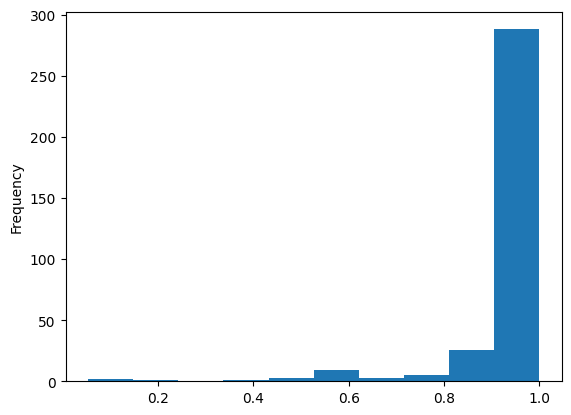

In [663]:
RESULT_DIR = "./genexpt/20230416_2dtanh_reg/"
# RESULT_DIR = "./genexpt/20230417_2dtanh_h3_reg/"
# RESULT_DIR = "./genexpt/20230420_large_tanh_bias/"
# RESULT_DIR = "./genexpt/20230420_large_tanh_bias/"




with open(f"{RESULT_DIR}/all_result.json") as infile:
    all_result = json.load(infile)
print(f"Num experiments: {len(all_result)}")

rec = []
for x in all_result:
    rec.append([
        x["n"], 
        x["BL"], 
        x["Bg"], 
#         x["truth_entropy"],
        x["rng_seed"], 
        x["rlct_estimation"]["slope"],
        x["rlct_estimation"]["intercept"],
        x["rlct_estimation"]["r^2"]
    ])
df_result = pd.DataFrame(
    rec, 
    columns=[
        "n", "BL", "Bg", 
#         "truth_entropy", 
        "rng_seed", ESTLAMBDA_KEY, ESTENERGY_KEY, RSQUARED_KEY]
).sort_values("n")

df_result[ESTENERGY_KEY] /= df_result["n"]

df_result[RSQUARED_KEY].plot(kind="hist")
num_bad = sum(df_result[RSQUARED_KEY] < 0.9)
total = df_result.shape[0]
print(f"Number of bad regression: {num_bad} / {total} ({num_bad / total * 100:.2f})")

df_result = df_result[df_result[RSQUARED_KEY] > 0.9]

df_result

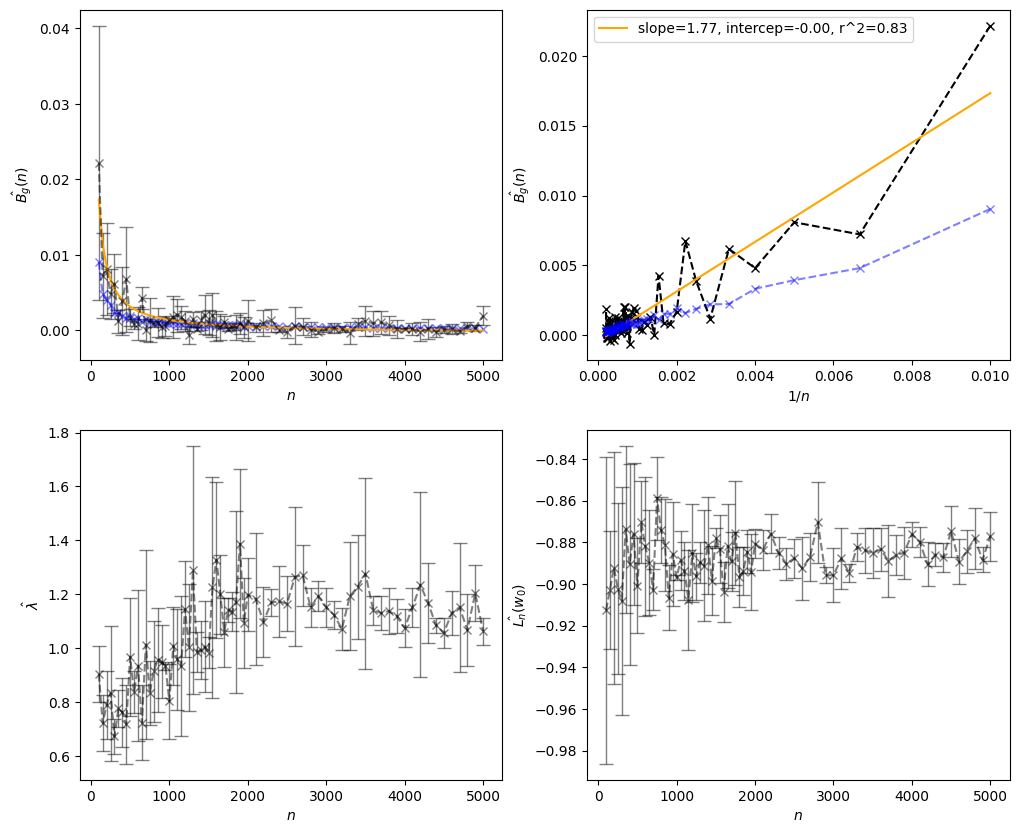

In [664]:
df = df_result.groupby("n").agg(["mean", "median", "std", "max", "min"]).reset_index()

key = "Bg"
ns = df["n"]
bgs = df[key]["mean"]
bgs_std = df[key]["std"]
bgs_max = df[key]["max"]
bgs_min = df[key]["min"]

rlcts = df[ESTLAMBDA_KEY]["mean"]
rlcts_std = df[ESTLAMBDA_KEY]["std"]
energies = df[ESTENERGY_KEY]["mean"]
energies_std = df[ESTENERGY_KEY]["std"]


slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / ns, bgs)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
ax = axes[0][0]
# ax.errorbar(ns, bgs, yerr=bgs_std, fmt="kx--", capsize=5, elinewidth=1, alpha=0.5)
ax.errorbar(ns, bgs, yerr=bgs_std, fmt="kx--", capsize=5, elinewidth=1, alpha=0.5)
# ax.plot(ns, windowed_average(bgs, window_size=7))
ax.plot(ns, rlcts / ns, "bx--", alpha=0.5)
ax.plot(ns, slope / ns + intercept, color="orange")

ax.set_xlabel("$n$")
ax.set_ylabel("$\hat{B_g}(n)$")


ax = axes[0][1]
ax.plot(1 / ns, bgs, "kx--")
ax.set_xlabel("$1/n$")
ax.set_ylabel("$\hat{B_g}(n)$")

xs = 1.0 / ns
xrange = np.linspace(xs.min(), xs.max(), num=100)
ax.plot(xrange, slope * xrange + intercept, 
        label=f"slope={slope:.2f}, intercep={intercept:.2f}, r^2={r_val**2:.2f}", 
       color="orange")
ax.plot(1 / ns, rlcts / ns, "bx--", alpha=0.5)
# ax.set_xscale("log")
ax.legend();


ax = axes[1][0]
ax.errorbar(ns, rlcts, yerr=rlcts_std, fmt="kx--", capsize=5, elinewidth=1, alpha=0.5)
ax.set_xlabel("$n$")
ax.set_ylabel(ESTLAMBDA_KEY)


ax = axes[1][1]
ax.errorbar(ns, energies, yerr=energies_std, fmt="kx--", capsize=5, elinewidth=1, alpha=0.5)
ax.set_xlabel("$n$")
ax.set_ylabel(ESTENERGY_KEY);


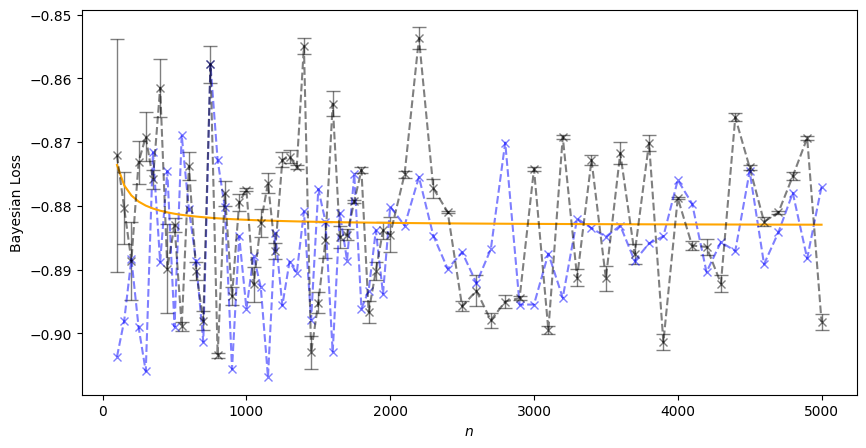

In [665]:
df = df_result.groupby("n").agg(["mean", "median", "std"]).reset_index()
ns = df["n"]
bls = df["BL"]["mean"]
bls_std = df["BL"]["std"]
rlcts = df[ESTLAMBDA_KEY]["mean"]
rlcts_std = df[ESTLAMBDA_KEY]["std"]
energies = df[ESTENERGY_KEY]["mean"]
energies_std = df[ESTENERGY_KEY]["std"]


slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / ns, bls)

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
ax = axes

ax.errorbar(ns, bls, yerr=bgs_std, fmt="kx--", capsize=5, elinewidth=1, alpha=0.5)
# ax.plot(ns, windowed_average(bgs, window_size=7))
ax.plot(ns, energies + rlcts / ns, "bx--", alpha=0.5)
ax.plot(ns, slope / ns + intercept, color="orange")
ax.set_xlabel("$n$")
ax.set_ylabel("Bayesian Loss");


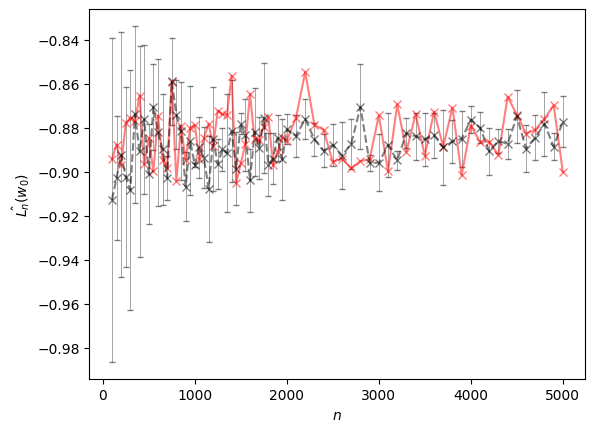

In [666]:
fig, ax = plt.subplots()
ax.errorbar(ns, energies, yerr=energies_std, fmt="kx--", capsize=2, elinewidth=0.5, alpha=0.5)
ax.set_xlabel("$n$")
ax.set_ylabel(ESTENERGY_KEY);


other_energy = df["BL"] - df["Bg"]
other_energy = other_energy["mean"]
ax.plot(ns, other_energy, "rx-", alpha=0.5)


# ax.plot(ns, df["truth_entropy"]["mean"], "bx-", alpha=0.5)


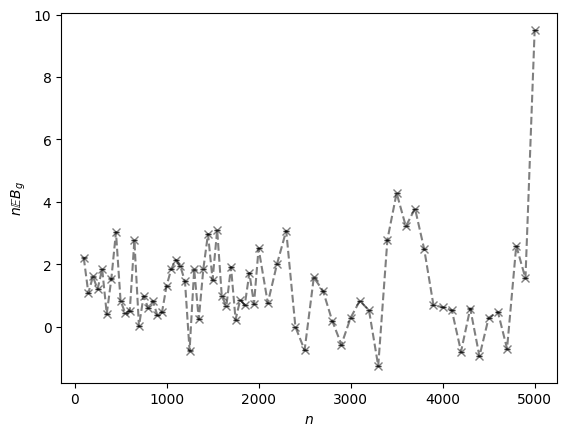

In [667]:
fig, ax = plt.subplots()
ax.errorbar(ns, ns * bgs, yerr=bgs_std, fmt="kx--", capsize=2, elinewidth=0.5, alpha=0.5)
ax.set_xlabel("$n$")
ax.set_ylabel("$n \mathbb{E}B_g$");


# $n \mathbb{E}_n B_g$ vs $n$

In [798]:
! jq -s . $( find ./genexpt/test5 -name "result*.json") > ./genexpt/test5/all_result.json

In [799]:
RESULT_DIR = "./genexpt/test5"
with open(f"{RESULT_DIR}/all_result.json") as infile:
    all_result = json.load(infile)
print(f"Num experiments: {len(all_result)}")

rec = []
keys = all_result[0].keys()
for x in all_result:
    rec.append([x[k] for k in keys])
df_result = pd.DataFrame(rec, columns=keys)
df_result["nBg"] = df_result["n"] * df_result["Bg"]
df_result

Num experiments: 200


,rng_seed,n,BL,BLt,GL,GLt,truth_entropy,Gg,Bg,nBg
0,8,704,1.415142,1.398726,1.416172,1.399240,1.414882,0.001291,0.000260,0.183205
1,4,704,1.425455,1.410741,1.426514,1.411281,1.425377,0.001137,0.000078,0.055054
2,5,704,1.425987,1.443685,1.427031,1.444200,1.421009,0.006023,0.004978,3.504471
3,9,704,1.422800,1.426410,1.423823,1.426930,1.422806,0.001016,-0.000007,-0.004700
4,2,704,1.408419,1.418294,1.409427,1.418808,1.408302,0.001126,0.000117,0.082329
...,...,...,...,...,...,...,...,...,...,...
195,3,1625,1.413513,1.420927,1.414186,1.421192,1.413500,0.000686,0.000013,0.021309
196,8,1625,1.415811,1.429820,1.416434,1.430100,1.414882,0.001553,0.000929,1.509622
197,4,1625,1.431737,1.456673,1.450783,1.469015,1.425377,0.025406,0.006360,10.334700
198,5,1625,1.421162,1.427992,1.421807,1.428267,1.421009,0.000798,0.000153,0.249311


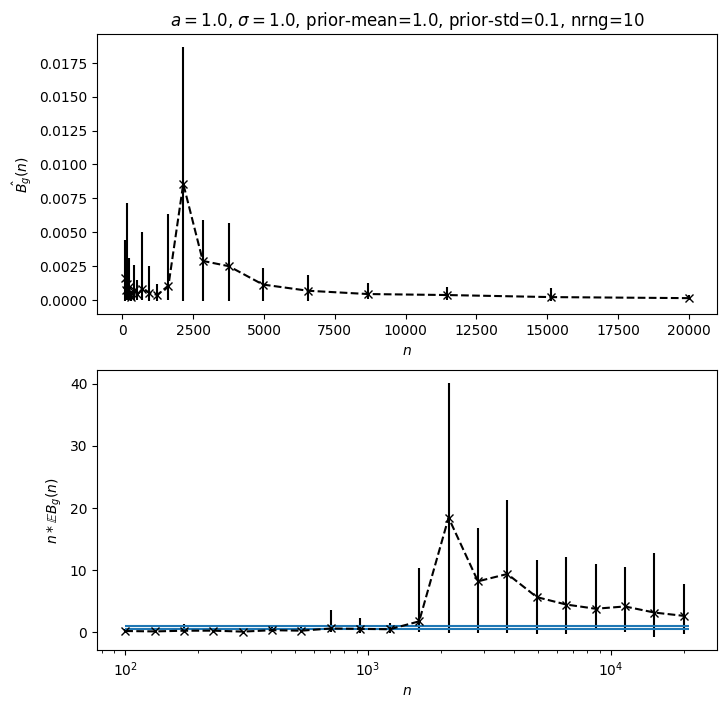

In [801]:
df = df_result.groupby("n").agg(["mean", "std", "max", "min"])
ns = df.index
bg_mean = df["Bg"]["mean"]
bg_std = df["Bg"]["std"]
bg_min = df["Bg"]["min"]
bg_max = df["Bg"]["max"]

nbg_mean = df["nBg"]["mean"]
nbg_std = df["nBg"]["std"]
nbg_min = df["nBg"]["min"]
nbg_max = df["nBg"]["max"]


fig, axes = plt.subplots(2, 1, figsize=(8, 8))
ax = axes[0]
ax.errorbar(ns, bg_mean, yerr=[bg_mean - bg_min, bg_max - bg_mean], fmt="kx--")
ax.set_xlabel("$n$")
ax.set_ylabel("$\hat{B_g}(n)$")
ax.set_title("$a=1.0$, $\sigma=1.0$, prior-mean=1.0, prior-std=0.1, nrng=10")
# ax.set_xscale("log")

ax = axes[1]
ax.errorbar(ns, nbg_mean, yerr=[nbg_mean - nbg_min, nbg_max - nbg_mean], fmt="kx--")
xmin, xmax = ax.get_xlim()
ax.hlines([0.5, 1.0], xmin=ns.min(), xmax=xmax)
ax.set_xscale("log")
ax.set_xlabel("$n$")
ax.set_ylabel("$n * \mathbb{E}B_g(n)$");


-0.04703019454255508 0.0013762922499034624


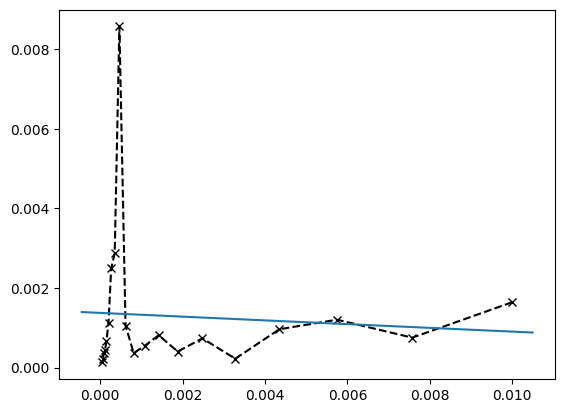

In [802]:
slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / ns, bg_mean)
print(slope, intercept)
fig, ax = plt.subplots()
ax.plot(1 / ns, bg_mean, "kx--");
invns = np.linspace(*ax.get_xlim())
ax.plot(invns, intercept + invns * slope);

# Slurm sweep

In [808]:
NSTART = 50
NEND = 20000
CONFIG_RANGES = dict(
    a=[0.1, 0.3, 0.5, 0.7, 0.9, 1.1],
    sigma_obs=[0.1, 0.5, 1.0],
    prior_std=[0.1, 0.5, 1.0, 5.0],
    num_training_data=[
        int(n) for n in np.logspace(np.log10(NSTART), np.log10(NEND), base=10, num=20)
    ],

)

def get_config_vals(index):
    keys, values = zip(*CONFIG_RANGES.items())
    all_vals = list(itertools.product(*values))
    if index >= len(all_vals):
        raise ValueError(
            f"Index {index} exceed length of all available configurations ({len(all_vals)})"
        )
    config = dict(zip(keys, all_vals[index]))
    return config



RESULT_DIR = "./genexpt/1htanhsweep/20230425/"
rec = []
for i in range(0, 1400):
    with open(f"{RESULT_DIR}/expt{i}/all_result.json") as infile:
        all_result = json.load(infile)
        
    keys = list(all_result[0].keys())
    keys.remove("rlct_estimation")
    config_keys = list(CONFIG_RANGES.keys())
    config = get_config_vals(i)
    if len(all_result) != 20:
        print(i, len(all_result), config)
    for x in all_result:
        r = [i] + [x.get(k) for k in keys] + [config.get(k) for k in config_keys]
        try: 
            rlct_rec = x["rlct_estimation"]
            r += [rlct_rec["slope"], rlct_rec["intercept"]]
        except KeyError:
            r += [None, None]
        rec.append(r)
df_result = pd.DataFrame(rec, columns=["expt"] + keys + config_keys + ["rlct", "energy"])
df_result["nBg"] = df_result["n"] * df_result["Bg"]
df_result

318 16 {'a': 0.3, 'sigma_obs': 0.1, 'prior_std': 5.0, 'num_training_data': 14590}
319 14 {'a': 0.3, 'sigma_obs': 0.1, 'prior_std': 5.0, 'num_training_data': 20000}
558 18 {'a': 0.5, 'sigma_obs': 0.1, 'prior_std': 5.0, 'num_training_data': 14590}
559 16 {'a': 0.5, 'sigma_obs': 0.1, 'prior_std': 5.0, 'num_training_data': 20000}


,expt,rng_seed,n,BL,BLt,GL,GLt,truth_entropy,Gg,Bg,a,sigma_obs,prior_std,num_training_data,rlct,energy,nBg
0,0,10,49,-0.883642,-1.023843,-0.878237,-1.022543,-0.887035,0.008798,0.003393,0.1,0.1,0.1,49,0.009675,-50.037604,0.166277
1,0,7,49,-0.876508,-0.912924,-0.872307,-0.911773,-0.884712,0.012405,0.008204,0.1,0.1,0.1,49,0.003592,-44.668228,0.402004
2,0,0,49,-0.868575,-0.899532,-0.863008,-0.898102,-0.880769,0.017762,0.012194,0.1,0.1,0.1,49,0.011048,-43.946511,0.597496
3,0,16,49,-0.879506,-1.005818,-0.874616,-1.005100,-0.888049,0.013433,0.008544,0.1,0.1,0.1,49,0.002727,-49.248860,0.418634
4,0,14,49,-0.870968,-0.936316,-0.866627,-0.935006,-0.875803,0.009176,0.004836,0.1,0.1,0.1,49,0.003790,-45.799708,0.236945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27979,1399,17,20000,1.409255,1.422557,1.409658,1.422605,1.409079,0.000579,0.000176,1.1,1.0,0.5,20000,0.648003,28452.571933,3.511906
27980,1399,10,20000,1.415665,1.420095,1.416167,1.420140,1.415550,0.000618,0.000115,1.1,1.0,0.5,20000,0.599403,28402.866717,2.307892
27981,1399,15,20000,1.419425,1.418957,1.419913,1.419004,1.419500,0.000413,-0.000075,1.1,1.0,0.5,20000,0.628591,28380.179668,-1.506805
27982,1399,1,20000,1.415901,1.426135,1.416504,1.426182,1.414852,0.001652,0.001048,1.1,1.0,0.5,20000,0.562970,28523.914975,20.968914


Num data points: 400


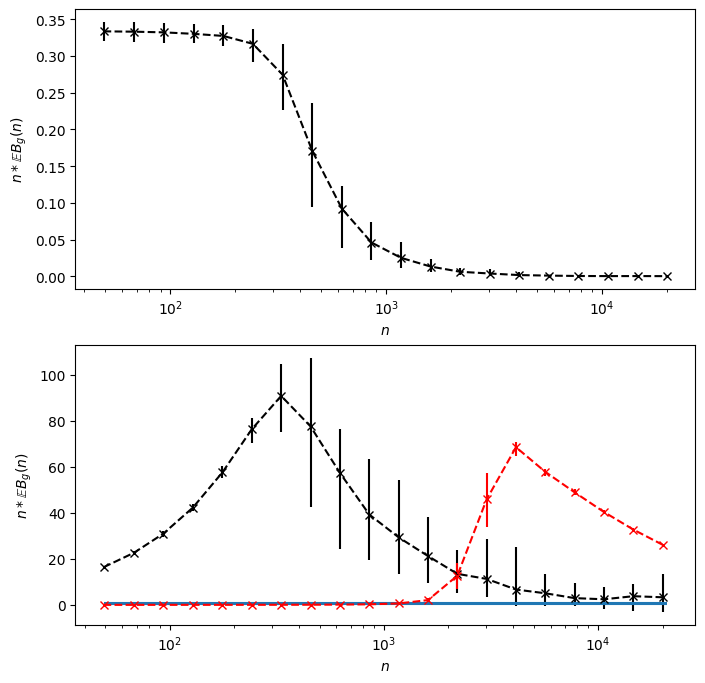

In [832]:
df = df_result
df = df[
    (df["a"] == 1.1) 
    & (np.isclose(df["sigma_obs"], 1.0))
    & (np.isclose(df["prior_std"], 0.1))
]
print(f"Num data points: {df.shape[0]}")
df = df.groupby("n").agg(["mean", "std", "max", "min"])
ns = df.index
bg_mean = df["Bg"]["mean"]
bg_std = df["Bg"]["std"]
bg_min = df["Bg"]["min"]
bg_max = df["Bg"]["max"]

nbg_mean = df["nBg"]["mean"]
nbg_std = df["nBg"]["std"]
nbg_min = df["nBg"]["min"]
nbg_max = df["nBg"]["max"]

rlct_mean = df["rlct"]["mean"]
rlct_min = df["rlct"]["min"]
rlct_max = df["rlct"]["max"]



fig, axes = plt.subplots(2, 1, figsize=(8, 8))
ax = axes[0]
ax.errorbar(ns, bg_mean, yerr=[bg_mean - bg_min, bg_max - bg_mean], fmt="kx--")
ax.set_xlabel("$n$")
ax.set_ylabel("$n * \mathbb{E}B_g(n)$");
# ax.set_title("$a=0.2$, $\sigma=0.1$, prior-std=5.0, nrng=20")
ax.set_xscale("log")

ax = axes[1]
ax.errorbar(ns, nbg_mean, yerr=[nbg_mean - nbg_min, nbg_max - nbg_mean], fmt="kx--")
ax.errorbar(ns, rlct_mean, yerr=[rlct_mean - rlct_min, rlct_max - rlct_mean], fmt="rx--")
xmin, xmax = ax.get_xlim()
ax.hlines([0.5, 1.0], xmin=ns.min(), xmax=xmax)
ax.set_xscale("log")
ax.set_xlabel("$n$")
ax.set_ylabel("$n * \mathbb{E}B_g(n)$");


In [828]:
# df_config = pd.DataFrame.from_dict({i: get_config_vals(i) for i in range(1400)}, orient="index")
    
# for a, sigma_obs, prior_std in sorted(set(map(tuple, df_config.iloc[:, :3].values))):
#     print(a, sigma_obs, prior_std)
#     df = df[
#         (np.isclose(df["a"], a))
#         & (np.isclose(df["sigma_obs"], sigma_obs))
#         & (np.isclose(df["prior_std"], prior_std))
#     ]
# #     if df.shape[0] != 400:
# #         print(i, df.shape[0], config)
#     print(f"Num data points: {df.shape[0]}")
#     df = df.groupby("n").agg(["mean", "std", "max", "min", "count"])
#     count = df["expt"]["count"]
#     ns = df.index
#     bg_mean = df["Bg"]["mean"]
#     bg_std = df["Bg"]["std"]
#     bg_min = df["Bg"]["min"]
#     bg_max = df["Bg"]["max"]

#     nbg_mean = df["nBg"]["mean"]
#     nbg_std = df["nBg"]["std"]
#     nbg_min = df["nBg"]["min"]
#     nbg_max = df["nBg"]["max"]


#     fig, axes = plt.subplots(2, 1, figsize=(8, 8))
#     ax = axes[0]
#     ax.errorbar(ns, bg_mean, yerr=[bg_mean - bg_min, bg_max - bg_mean], fmt="kx--")
#     ax.set_xlabel("$n$")
#     ax.set_ylabel("$n * \mathbb{E}B_g(n)$");
#     ax.set_title(
#         f"$a={a}$,"
#         f" $\sigma={sigma_obs}$,"
#         f" prior_mean={0.0},"
#         f" prior-std={prior_std},"
#         f" numrngseed={count.min(), count.max()}"
#     )
#     ax.set_xscale("log")

#     ax = axes[1]
#     ax.errorbar(ns, nbg_mean, yerr=[nbg_mean - nbg_min, nbg_max - nbg_mean], fmt="kx--")
#     xmin, xmax = ax.get_xlim()
#     ax.hlines([0.5, 1.0], xmin=ns.min(), xmax=xmax)
#     ax.set_xscale("log")
#     ax.set_xlabel("$n$")
#     ax.set_ylabel("$n * \mathbb{E}B_g(n)$");
    
#     fig.savefig(f"./genexpt/1htanhsweep/20230425_images_only/plots_a={a}_sigma={sigma_obs}_prior-std={prior_std}.png")


0.1 0.1 0.1
Num data points: 0


KeyError: 'count'

# SLURM sweep 2

In [59]:
# expt on 20230426
# RESULT_DIR = "./genexpt/1htanhsweep/20230427/"
# RESULT_DIR = "./genexpt/1htanhsweep/20230430/"
RESULT_DIR = "./genexpt/1htanhsweep/20230503"
all_result_list = []
for i in range(0, 524):
    try: 
        with open(f"{RESULT_DIR}/expt{i}/all_result.json") as infile:
            all_result = json.load(infile)
        all_result_list.append(all_result)
    except FileNotFoundError:
        break
sum([len(x) for x in all_result_list])

26200

In [60]:
NSTART = 100
NEND = 20000
NUMRNGSEEDS = 100
CONFIG_RANGES = dict(
    a=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    num_training_data=[10, 30, 50, 70, 90] + [
        int(n) for n in np.logspace(np.log10(NSTART), np.log10(NEND), base=10, num=20)
    ],
    sigma_obs=[0.1, 1.0],
    prior_std=[0.1, 5.0],
    prior_mean=[0.0, 0.6, 1.0], 
)
def get_config_vals(index):
    keys, values = zip(*CONFIG_RANGES.items())
    all_vals = list(itertools.product(*values))
    if index >= len(all_vals):
        raise ValueError(
            f"Index {index} exceed length of all available configurations ({len(all_vals)})"
        )
    config = dict(zip(keys, all_vals[index]))
    return config



keys = sorted(list(all_result_list[0][0].keys()))
keys.remove("commandline_args")
config_keys = list(CONFIG_RANGES.keys())
cmd_fields = ["num_training_data", "sigma_obs", "prior_std", "prior_mean"]
rec = []
for i, all_result in enumerate(all_result_list):
    config = get_config_vals(i)
    if len(all_result) < 30:
        print(i, len(all_result), config)

    for x in all_result:
        cmd_args = x["commandline_args"]
        r = [i] + [x.get(k) for k in keys] + [cmd_args.get(k) for k in cmd_fields] 
        r += [x.get("true_param")[0][0][0]]
        rec.append(r)

columns = ["expt"] + keys + cmd_fields + ['a']
df_result = pd.DataFrame(rec, columns=columns)
# df_result["nBg"] = df_result["n"] * df_result["Bg"]
df_result["WAIC - S_n"] = df_result["WAIC"] - df_result["truth_entropy_train"]
df_result["WBIC - nS_n"] = df_result["WBIC"] - df_result["n"] * df_result["truth_entropy_train"]
df_result["BLt - S_n"] = df_result["BLt"] - df_result["truth_entropy_train"]
df_result["GLt - S_n"] = df_result["GLt"] - df_result["truth_entropy_train"]

print(df_result.columns)
df_result

Index(['expt', 'BL', 'BLt', 'Bg', 'GL', 'GLt', 'Gg', 'V_n', 'WAIC', 'WBIC',
       'n', 'rng_seed', 'true_param', 'truth_entropy', 'truth_entropy_train',
       'num_training_data', 'sigma_obs', 'prior_std', 'prior_mean', 'a',
       'WAIC - S_n', 'WBIC - nS_n', 'BLt - S_n', 'GLt - S_n'],
      dtype='object')


,expt,BL,BLt,Bg,GL,GLt,Gg,V_n,WAIC,WBIC,...,truth_entropy_train,num_training_data,sigma_obs,prior_std,prior_mean,a,WAIC - S_n,WBIC - nS_n,BLt - S_n,GLt - S_n
0,0,-0.881391,-0.814839,0.002772,-0.858258,-0.803876,0.025905,0.557601,-0.257238,-38.809975,...,-0.811368,50,0.1,10,0,0.0,0.554131,1.758431,-0.003471,0.007492
1,0,-0.886636,-1.019490,0.006870,-0.870697,-1.014260,0.022809,0.533050,-0.486440,-49.516312,...,-1.019123,50,0.1,10,0,0.0,0.532683,1.439848,-0.000367,0.004863
2,0,-0.871546,-0.892680,0.013567,-0.853667,-0.883228,0.031447,0.318293,-0.574387,-42.760990,...,-0.880692,50,0.1,10,0,0.0,0.306305,1.273589,-0.011989,-0.002537
3,0,-0.886527,-0.992803,0.013739,-0.866177,-0.985986,0.034088,0.449535,-0.543268,-47.692448,...,-0.987026,50,0.1,10,0,0.0,0.443758,1.658869,-0.005777,0.001041
4,0,-0.882109,-0.952479,0.005624,-0.860835,-0.944725,0.026898,0.271946,-0.680532,-46.068161,...,-0.950525,50,0.1,10,0,0.0,0.269993,1.458103,-0.001953,0.005800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26195,523,0.762284,0.715712,0.043185,0.795878,0.716689,0.076779,0.542247,1.257959,720.948486,...,0.716209,1000,0.5,10,0,1.1,0.541750,4.739850,-0.000496,0.000480
26196,523,0.899604,0.717036,0.177202,0.929523,0.717613,0.207120,0.533963,1.250999,721.721558,...,0.720673,1000,0.5,10,0,1.1,0.530326,1.048771,-0.003637,-0.003059
26197,523,0.724853,0.710161,0.001665,0.737695,0.711140,0.014508,0.462247,1.172408,715.916809,...,0.710135,1000,0.5,10,0,1.1,0.462273,5.782243,0.000026,0.001006
26198,523,0.734344,0.724707,0.009618,0.740546,0.725815,0.015820,0.503228,1.227934,731.975769,...,0.726378,1000,0.5,10,0,1.1,0.501556,5.597745,-0.001671,-0.000563


In [23]:
def _plot(df, plot_keys, groupby_key="expt"):
    for key in plot_keys:
        df[f"n{key}"] = df["n"] * df[key]
    df = df.groupby(groupby_key).agg(["mean", "std", "max", "min", "count"]).reset_index()
    ns = df["n"]["mean"]
    
    # plot
    nrows = len(plot_keys)
    ncols = 3
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
    for i, key in enumerate(plot_keys):
        ax = axes[i][0]
        nkey = f"n{key}"
        mean = df[nkey]["mean"]
        std = df[nkey]["std"]
        count = df[nkey]["count"]
        minimum = df[nkey]["min"]
        maximum = df[nkey]["max"]
        ax.errorbar(
            ns, mean, 
            yerr=[mean - minimum, maximum - mean],
            fmt="kx--", 
            label="range", 
            ecolor="blue", 
            capsize=8,
            alpha=0.3
        )
        ax.errorbar(
            ns, 
            mean, 
            yerr=std, 
            fmt="kx--", 
            label="stderr", 
            ecolor="red", 
            alpha=0.3, 
            capsize=4, 
        )
        ax.set_xscale("log")
        ax.set_xlabel("$n$")
        ax.set_ylabel("$n \mathbb{E}[" + key + "]$");
        ax.legend()

        ax = axes[i][1]
        mean = df[key]["mean"]
        std = df[key]["std"]
        count = df[key]["count"]
        minimum = df[key]["min"]
        maximum = df[key]["max"]
        ax.errorbar(
            ns, mean, 
            yerr=[mean - minimum, maximum - mean],
            fmt="kx--", 
            label="range", 
            ecolor="blue", 
            capsize=8,
            alpha=0.3
        )
        ax.errorbar(
            ns, 
            mean, 
            yerr=std, 
            fmt="kx--", 
            label="stderr", 
            ecolor="red", 
            alpha=0.3, 
            capsize=4, 
        )

        ax.set_xscale("log")
        ax.set_xlabel("$n$")
        ax.set_ylabel("$\mathbb{E}[" + key + "]$");
        ax.legend()
        
        if i == 0:
            ax.set_title(
                f"$a={a}$,"
                f" $\sigma={sigma_obs}$,"
                f" $\mu_\\varphi={0.0}$,"
                f" $\sigma_\\varphi={prior_std}$,"
                f" rep(min, max)={count.min(), count.max()}", fontdict={"fontsize": 15}
            )


        ax = axes[i][2]
        ax.plot(ns, mean, "kx--", label="mean")
    #     ax.set_xscale('log')
        ax.legend()
        if key == "nBg":
            xmin, xmax = ax.get_xlim()
            ax.hlines([0.5, 1.0], xmin=ns.min(), xmax=xmax, linestyle="dashed", alpha=0.5)
    return fig, ax

def _plot_bayes_quartet(df, config, error_keys):
    df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
    ns = df["n"]["mean"]


    fig, ax = plt.subplots(figsize=(8, 8))
    for i, key in enumerate(error_keys):
        ax.plot()
        mean = df[key]["mean"]
        std = df[key]["std"]
        count = df[key]["count"]
        minimum = df[key]["min"]
        maximum = df[key]["max"]
        ax.plot(ns, mean, "x--", label=key)
    ax.set_xscale('log')
    ax.legend()
    ax.set_title(
        "Bayes Quartet: "
        f"$a={a}$,"
        f" $\sigma={sigma_obs}$,"
        f" $\mu_\\varphi={0.0}$,"
        f" $\sigma_\\varphi={prior_std}$,"
        f" rep(min, max)={count.min(), count.max()}", fontdict={"fontsize": 10}
    )

    ax.set_xlabel("$n$")
    ax.set_ylabel("Error")
    return fig, ax

def _plot_column(df, plot_keys):
    for key in plot_keys:
        df[f"n{key}"] = df["n"] * df[key]
    df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
    ns = df["n"]["mean"]
    
    # plot
    nrows = len(plot_keys)
    ncols = 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
    for i, key in enumerate(plot_keys):
        ax = axes[i][0]
        mean = df[key]["mean"]
        std = df[key]["std"]
        count = df[key]["count"]
        minimum = df[key]["min"]
        maximum = df[key]["max"]
        ax.errorbar(
            ns, mean, 
            yerr=[mean - minimum, maximum - mean],
            fmt="kx--", 
            label="range", 
            ecolor="blue", 
            capsize=8,
            alpha=0.3
        )
        ax.errorbar(
            ns, 
            mean, 
            yerr=std, 
            fmt="kx--", 
            label="stderr", 
            ecolor="red", 
            alpha=0.3, 
            capsize=4, 
        )

        ax.set_xscale("log")
        ax.set_xlabel("$n$")
        ax.set_ylabel("$\mathbb{E}[" + key + "]$");
        ax.legend()
        
        if i == 0:
            ax.set_title(
                f"$a={a}$,"
                f" $\sigma={sigma_obs}$,"
                f" $\mu_\\varphi={0.0}$,"
                f" $\sigma_\\varphi={prior_std}$,"
                f" rep(min, max)={count.min(), count.max()}", fontdict={"fontsize": 15}
            )


        ax = axes[i][1]
        ax.plot(ns, mean, "kx--", label="mean")
    #     ax.set_xscale('log')
        ax.legend()
        if key == "nBg":
            xmin, xmax = ax.get_xlim()
            ax.hlines([0.5, 1.0], xmin=ns.min(), xmax=xmax, linestyle="dashed", alpha=0.5)
    return fig, ax
    

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


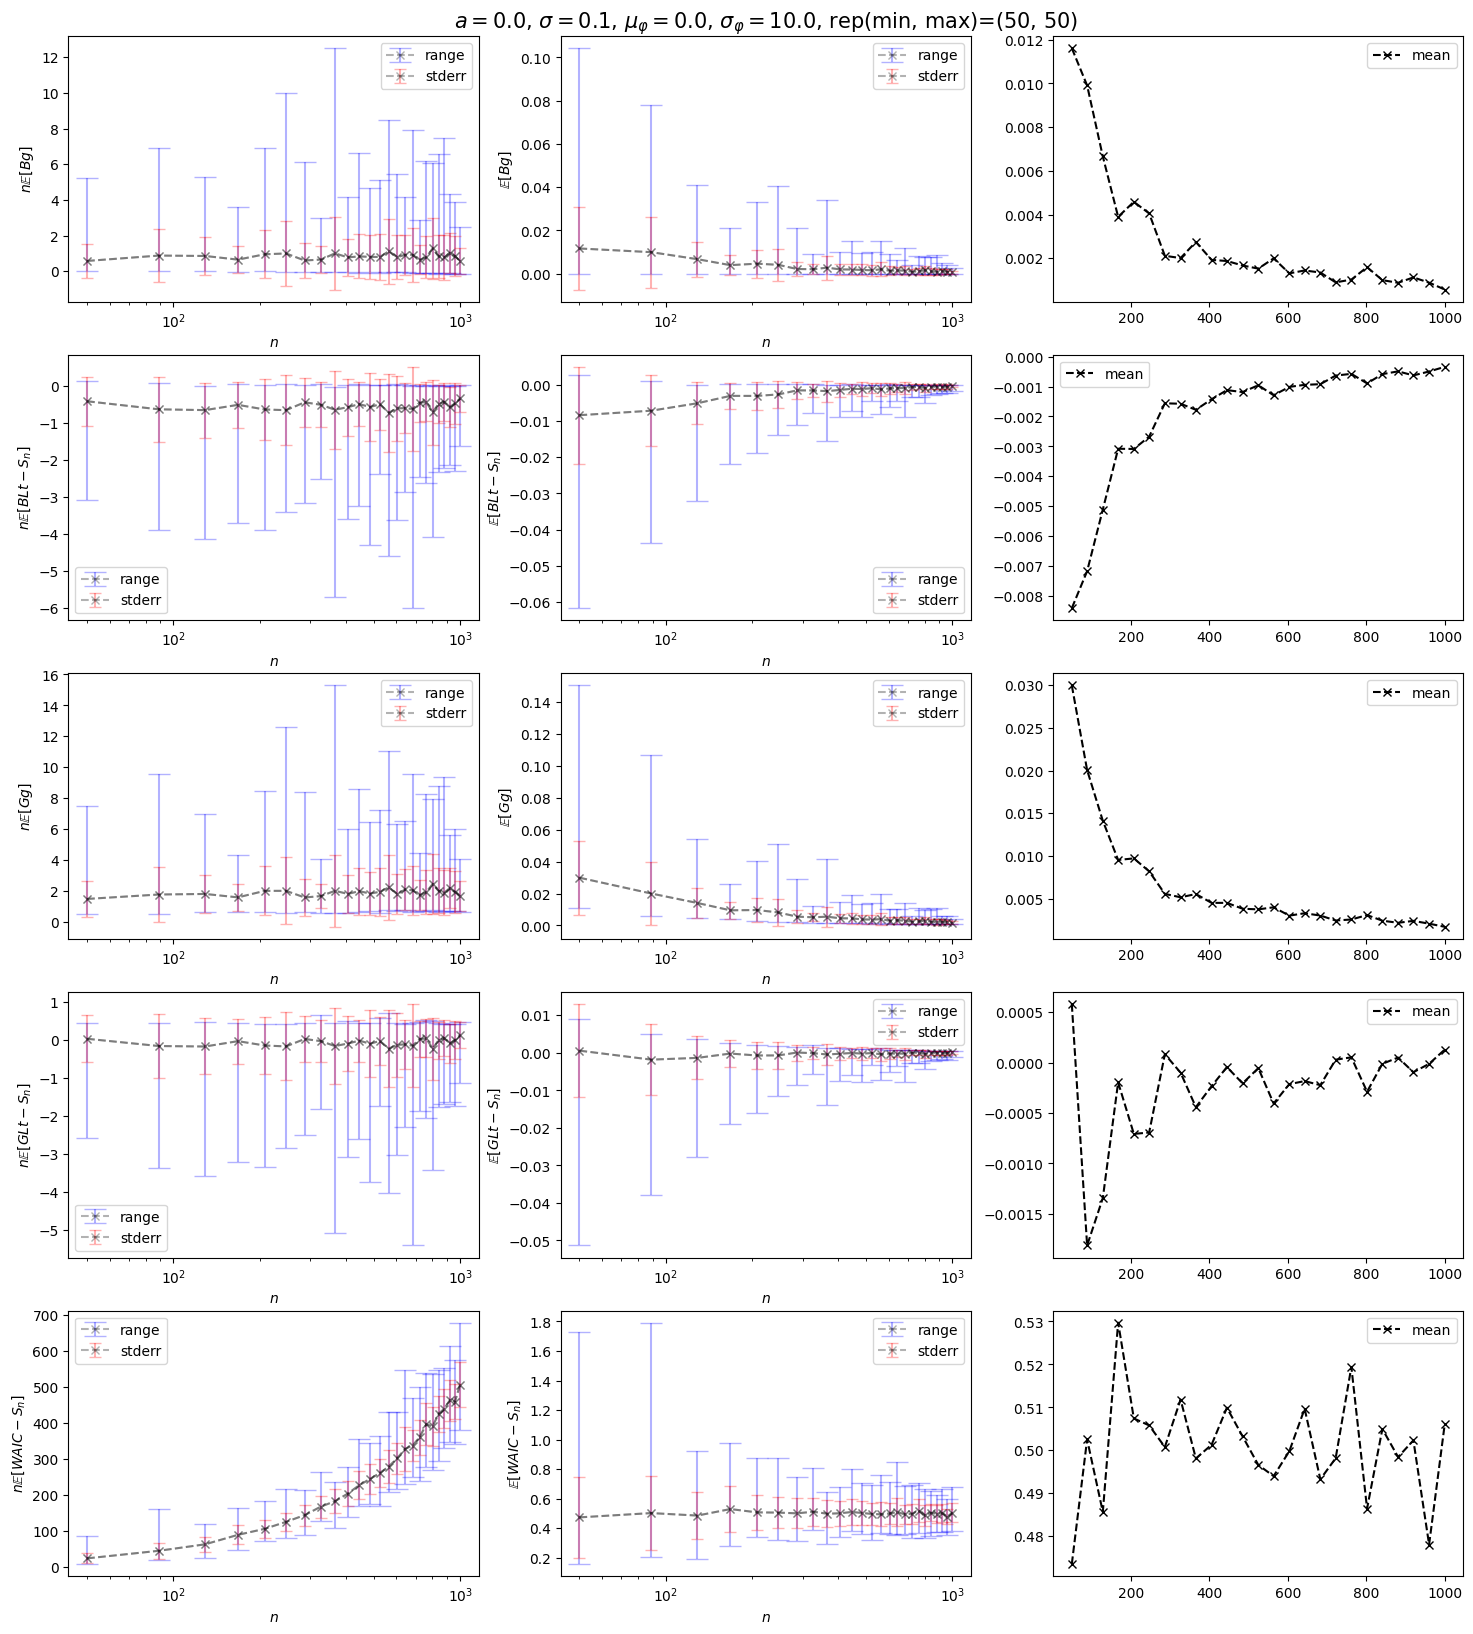

In [63]:
config = dict(
#     a="[3",
#     a="[2",
#     a="[5",
    a = 0.0,
    sigma_obs = 0.1, 
    prior_std = 10.0,
    prior_mean = 0.0,
)
plot_keys = [
    "Bg", "BLt - S_n", "Gg", "GLt - S_n", "WAIC - S_n", 
#     "WBIC - nS_n", "V_n"
]

# config values
a = config["a"]
sigma_obs = config["sigma_obs"]
prior_std = config["prior_std"]
prior_mean = config["prior_mean"]

# slice out data and compute stats. 
df = df_result.copy(deep=True)
df = df[
#     [a in b for b in df["a"]]
    (np.isclose(df["a"], a))
    & (np.isclose(df["sigma_obs"], sigma_obs))
    & (np.isclose(df["prior_std"], prior_std))
    & (np.isclose(df["prior_mean"], prior_mean))
].copy(deep=True)
fig, ax = _plot(df, config, plot_keys)
    

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Bayes Quartet: $a=0.0$, $\\sigma=0.1$, $\\mu_\\varphi=0.0$, $\\sigma_\\varphi=10.0$, rep(min, max)=(50, 50)'}, xlabel='$n$', ylabel='Error'>)

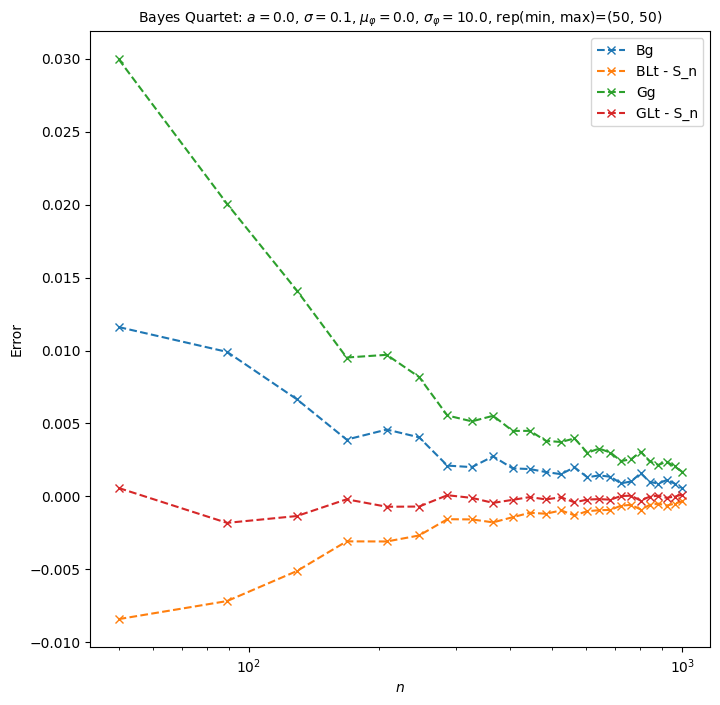

In [65]:
error_keys = [
    "Bg", "BLt - S_n", "Gg", "GLt - S_n", 
#     "WAIC - S_n"
]
    
_plot_bayes_quartet(df, config, error_keys)

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


(<Figure size 1200x1600 with 8 Axes>, <Axes: >)

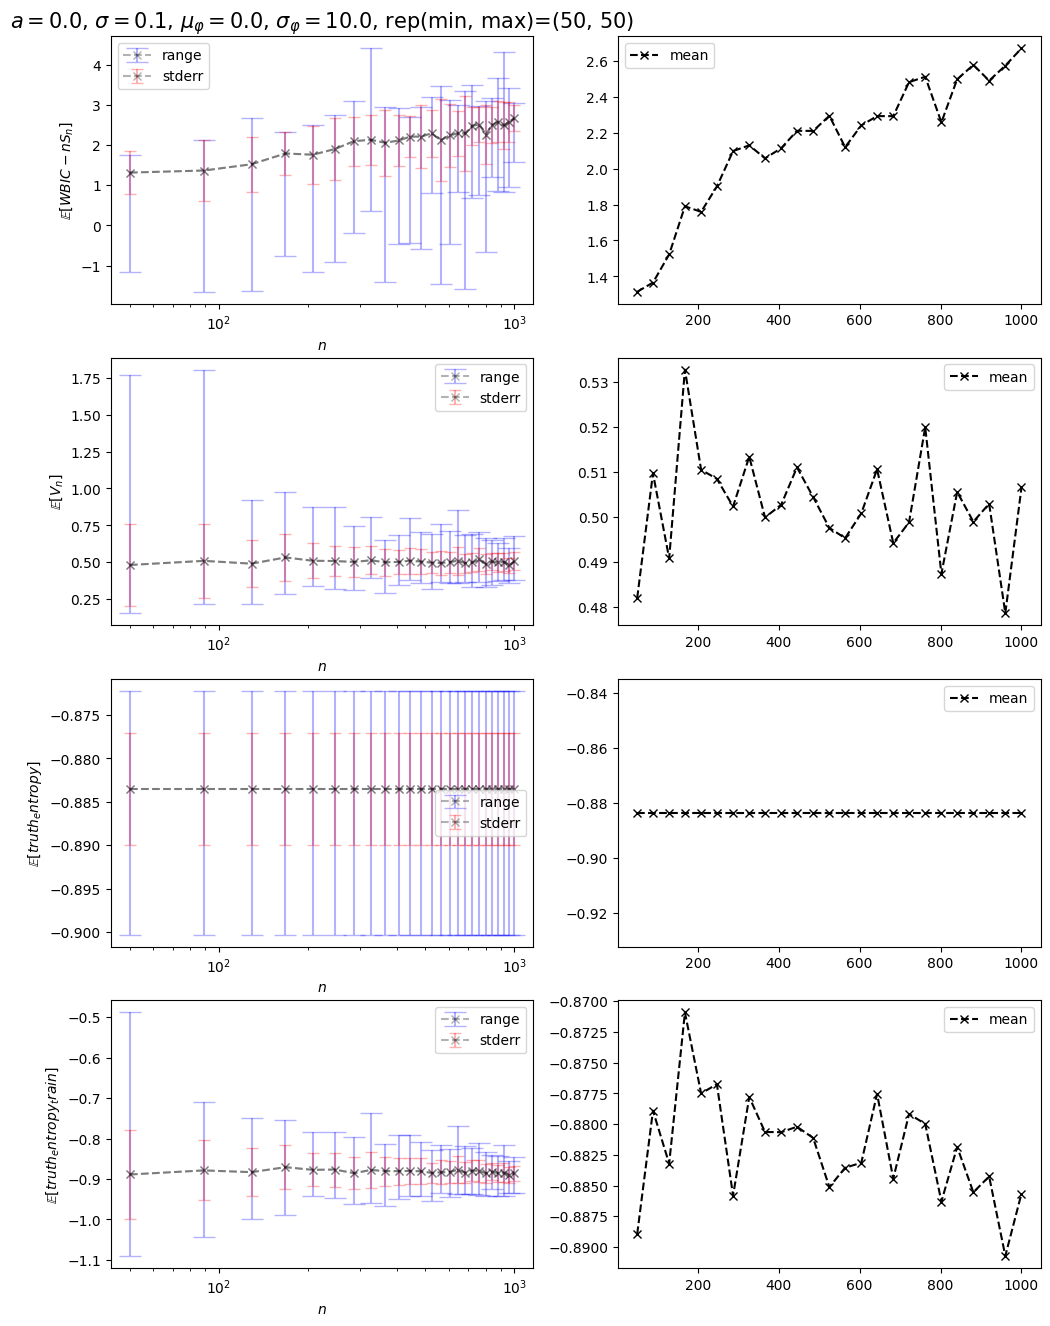

In [66]:
plot_keys = ["WBIC - nS_n", "V_n", "truth_entropy", "truth_entropy_train"]
_plot_column(df, config, plot_keys)


In [67]:
# OUTDIRPATH = "./genexpt/1htanhsweep/20230426_images_only/"
# OUTDIRPATH = "./genexpt/1htanhsweep/20230430_images_only/"
OUTDIRPATH = "./genexpt/1htanhsweep/20230503_images_only/"
config_cols = ['a', 'sigma_obs', 'prior_std', 'prior_mean']
config_set = set(map(tuple, df_result[config_cols].values))
   
plot_keys = [
    "Bg", "BLt - S_n", "Gg", "GLt - S_n", "WAIC - S_n", 
#     "WBIC - nS_n", "V_n"
]
quartet_keys = [
    "Bg", "BLt - S_n", "Gg", "GLt - S_n", 
]
other_keys = ["WBIC - nS_n", "V_n", "truth_entropy", "truth_entropy_train"]

    
for i, config_vals in enumerate(config_set):
    config = dict(zip(config_cols, config_vals))
    suffix = "_".join([f"{key}={config[key]}" for key in config_cols]) + ".png"
    print(i, suffix)
    # config values
    a = config["a"]
    sigma_obs = config["sigma_obs"]
    prior_std = config["prior_std"]
    prior_mean = config["prior_mean"]

    # slice out data and compute stats. 
    df = df_result.copy(deep=True)
    df = df[
    #     [a in b for b in df["a"]]
        (np.isclose(df["a"], a))
        & (np.isclose(df["sigma_obs"], sigma_obs))
        & (np.isclose(df["prior_std"], prior_std))
        & (np.isclose(df["prior_mean"], prior_mean))
    ].copy(deep=True)

    fig, ax = _plot(df, config, plot_keys)

    filename = "mainplot_" + suffix
    fig.savefig(os.path.join(OUTDIRPATH, filename))
    plt.close()
    
    fig, ax = _plot_bayes_quartet(df, config, quartet_keys)
    filename = "bayes_quartet_" + suffix
    fig.savefig(os.path.join(OUTDIRPATH, filename))
    plt.close()
    
    fig, ax = _plot_column(df, config, other_keys)
    filename = "others_" + suffix
    fig.savefig(os.path.join(OUTDIRPATH, filename))
    plt.close()


    

0 a=0.10000000149011612_sigma_obs=0.5_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


1 a=1.100000023841858_sigma_obs=1.0_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


2 a=0.30000001192092896_sigma_obs=0.5_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


3 a=0.0_sigma_obs=1.0_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


4 a=0.30000001192092896_sigma_obs=1.0_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


5 a=0.8999999761581421_sigma_obs=1.0_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


6 a=0.699999988079071_sigma_obs=1.0_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


7 a=0.10000000149011612_sigma_obs=1.0_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


8 a=0.5_sigma_obs=0.5_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


9 a=0.0_sigma_obs=0.1_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


10 a=0.10000000149011612_sigma_obs=0.1_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


11 a=0.0_sigma_obs=0.5_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


12 a=1.100000023841858_sigma_obs=0.1_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


13 a=0.5_sigma_obs=1.0_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


14 a=0.699999988079071_sigma_obs=0.1_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


15 a=1.100000023841858_sigma_obs=0.5_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


16 a=0.5_sigma_obs=0.1_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


17 a=0.8999999761581421_sigma_obs=0.5_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


18 a=0.8999999761581421_sigma_obs=0.1_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


19 a=0.30000001192092896_sigma_obs=0.1_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


20 a=0.699999988079071_sigma_obs=0.5_prior_std=10.0_prior_mean=0.0.png


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:4: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:94: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_87404/2299184853.py:125: FutureWarning: ['true_param'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby("expt").agg(["mean", "std", "max", "min", "count"])


# Normal mixtures experiments

In [1]:
import json 
import pandas as pd
import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import numpy as np
import seaborn as sns
import itertools
import os

# RESULT_DIR = "./nmm_expt/20230509_reg/"
# RESULT_DIR = "./nmm_expt/20230509_sing/"
# RESULT_DIR = "./nmm_expt/20230509_transition/"

# RESULT_DIR = "./nmm_expt/20230511_transition/"
# RESULT_DIR = "./nmm_expt/20230511_sing/"
# RESULT_DIR = "./nmm_expt/20230511_reg/"

# RESULT_DIR = "./nmm_expt/20230514_k2d4transition/"
RESULT_DIR = "./nmm_expt/20230514_k2d4reg/"
# RESULT_DIR = "./nmm_expt/20230514_k2d4sing/"

with open(f"{RESULT_DIR}/all_result.json") as infile:
    all_result = json.load(infile)
    rec = [
        {
#             **x['commandline_args'], 
            **{k: v for k, v in x.items() if k != 'commandline_args'}
        }
        for x in all_result
    ]
    
df_result = pd.DataFrame(rec)
df_result["WAIC - S_n"] = df_result["WAIC"] - df_result["truth_entropy_train"]
df_result["BLt - S_n"] = df_result["BLt"] - df_result["truth_entropy_train"]
df_result["GLt - S_n"] = df_result["GLt"] - df_result["truth_entropy_train"]

print(df_result.shape)

(14816, 15)


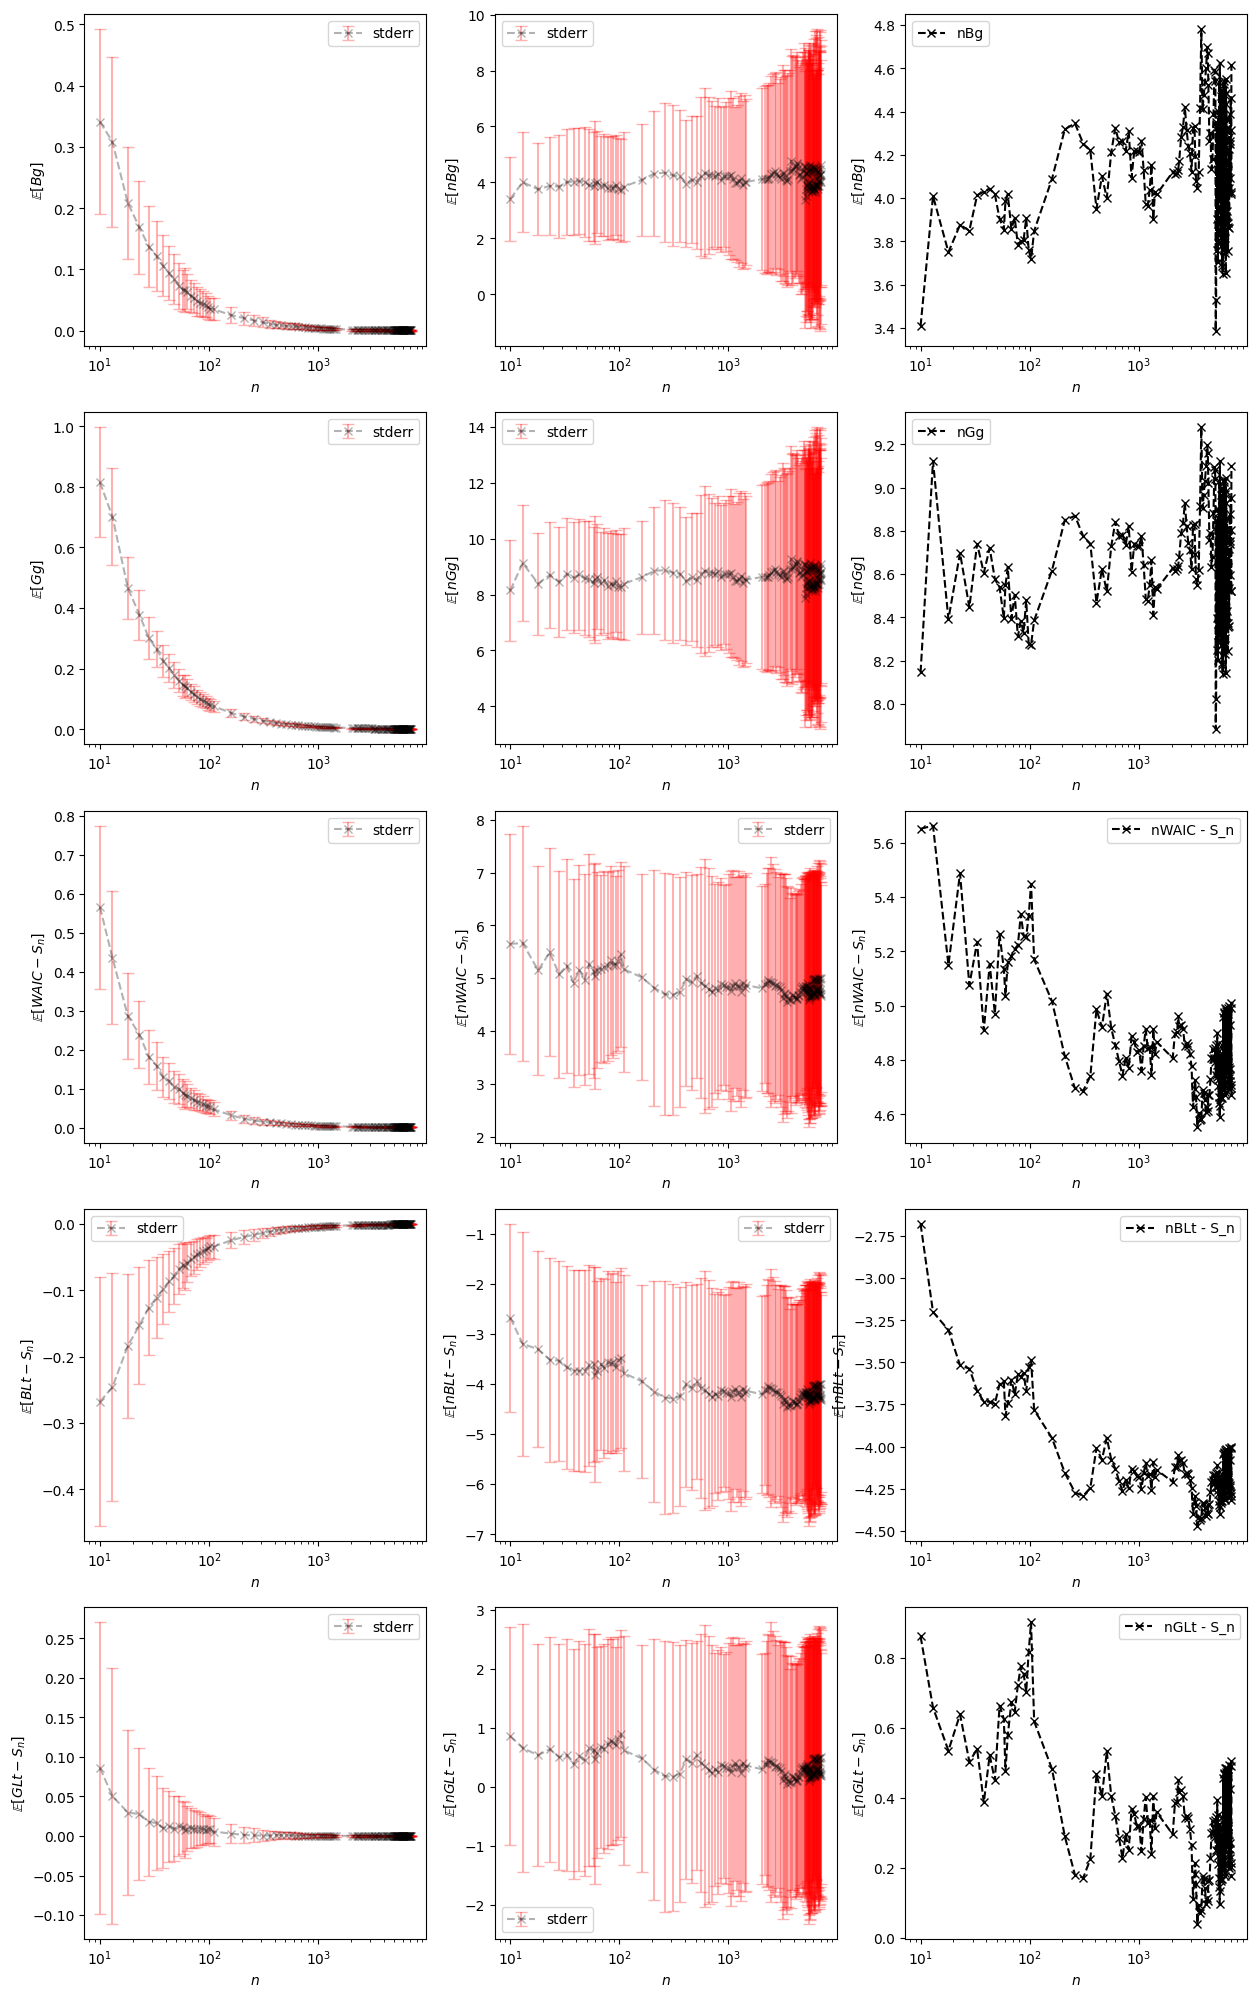

In [18]:
df = df_result.copy(deep=True)

plot_keys = [
    "Bg", 
    "Gg", 
    "WAIC - S_n", 
    "BLt - S_n", 
    "GLt - S_n"
]
for key in plot_keys:
    df[f"n{key}"] = df["n"] * df[key]

df = df.groupby(["n"]).agg(["mean", "std", "median", "min", "max"])
# df = df[df.index % 10 != 0]
# df = df[df.index < 6000]

ns = df.index
nrows = len(plot_keys)
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
for i, key in enumerate(plot_keys):
    ax = axes[i][0]
    mean = df[key]["mean"]
    std = df[key]["std"]
    minimum = df[key]["min"]
    maximum = df[key]["max"]
#     ax.errorbar(
#         ns, mean, 
#         yerr=[mean - minimum, maximum - mean],
#         fmt="kx--", 
#         label="range", 
#         ecolor="blue", 
#         capsize=8,
#         alpha=0.3
#     )
    ax.errorbar(
        ns, 
        mean, 
        yerr=std, 
        fmt="kx--", 
        label="stderr", 
        ecolor="red", 
        alpha=0.3, 
        capsize=4, 
    )
#     ax.set_xscale("log")
    ax.set_xlabel("$n$")
    ax.set_ylabel("$\mathbb{E}[" + key + "]$");
    ax.legend()
    
    
    ax = axes[i][1]
    key = f"n{key}"
    mean = df[key]["mean"]
    std = df[key]["std"]
    minimum = df[key]["min"]
    maximum = df[key]["max"]
#     ax.errorbar(
#         ns, mean, 
#         yerr=[mean - minimum, maximum - mean],
#         fmt="kx--", 
#         label="range", 
#         ecolor="blue", 
#         capsize=8,
#         alpha=0.3
#     )
    ax.errorbar(
        ns, 
        mean, 
        yerr=std, 
        fmt="kx--", 
        label="stderr", 
        ecolor="red", 
        alpha=0.3, 
        capsize=4, 
    )
#     ax.set_xscale("log")
    ax.set_xlabel("$n$")
    ax.set_ylabel("$\mathbb{E}[" + key + "]$");
    ax.legend()
    
    
    ax = axes[i][2]
    ax.plot(ns, mean, "kx--", label=key)
    ax.set_xlabel("$n$")
    ax.set_ylabel("$\mathbb{E}[" + key + "]$");
    ax.legend()


for ax in np.ravel(axes): ax.set_xscale('log')

In [ ]:
import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import numpy as np
import seaborn as sns
import itertools
import os

RESULT_DIRS = [
    "./nmm_expt/20230511_transition/", 
    "./nmm_expt/20230511_reg/", 
    "./nmm_expt/20230511_sing/"
]


# RESULT_DIRS = [
#     "./nmm_expt/20230514_k2d4transition/", 
#     "./nmm_expt/20230514_k2d4reg/", 
#     "./nmm_expt/20230514_k2d4sing/"
# ]

plot_keys = [
    "Bg", 
    "Gg", 
    "WAIC - S_n", 
    "BLt - S_n", 
    "GLt - S_n"
]
nrows = len(plot_keys)
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))


for result_dir in RESULT_DIRS:
    name = result_dir.split("_")[-1].strip("/")
    print(name)
    
    with open(f"{result_dir}/all_result.json") as infile:
        all_result = json.load(infile)
        rec = [
            {
    #             **x['commandline_args'], 
                **{k: v for k, v in x.items() if k != 'commandline_args'}
            }
            for x in all_result
        ]
    
    df_result = pd.DataFrame(rec)
    print(df_result.shape)
    df_result["WAIC - S_n"] = df_result["WAIC"] - df_result["truth_entropy_train"]
    df_result["BLt - S_n"] = df_result["BLt"] - df_result["truth_entropy_train"]
    df_result["GLt - S_n"] = df_result["GLt"] - df_result["truth_entropy_train"]
    df = df_result

    for key in plot_keys:
        df[f"n{key}"] = df["n"] * df[key]

    df = df.groupby(["n"]).agg(["mean", "std", "median", "min", "max"])
    # df = df[df.index % 10 != 0]
    df = df[df.index < 2000]

    ns = df.index
    for i, key in enumerate(plot_keys):
        ax = axes[i][0]
        mean = df[key]["mean"]
        std = df[key]["std"]
        minimum = df[key]["min"]
        maximum = df[key]["max"]
        ax.errorbar(
            ns, 
            mean, 
            yerr=std, 
            fmt="x--", 
            label=f"{name}_stderr", 
            ecolor="red", 
            alpha=0.3, 
            capsize=4, 
        )
        ax.set_xlabel("$n$")
        ax.set_ylabel("$\mathbb{E}[" + key + "]$");
        ax.legend()


        ax = axes[i][1]
        key = f"n{key}"
        mean = df[key]["mean"]
        std = df[key]["std"]
        minimum = df[key]["min"]
        maximum = df[key]["max"]
        ax.errorbar(
            ns, 
            mean, 
            yerr=std, 
            fmt="x--", 
            label=f"{name}_stderr", 
            ecolor="red", 
            alpha=0.3, 
            capsize=4, 
        )
        ax.set_xlabel("$n$")
        ax.set_ylabel("$\mathbb{E}[" + key + "]$");
        ax.legend()


        ax = axes[i][2]
        ax.plot(ns, mean, "x--", label=f"{name}_{key}")
        ax.set_xlabel("$n$")
        ax.set_ylabel("$\mathbb{E}[" + key + "]$");
        ax.legend()

    fig.suptitle(f"2 component d=2 normal mixture model, prior=N(0, 10**2)")
#     for ax in np.ravel(axes): ax.set_xscale('log')

transition
(11248, 12)
reg
(7917, 12)
sing
(4441, 12)
